<a href="https://colab.research.google.com/github/rhushikeshprabhune/Terrain-Identification-using-Deep-Neural-Networks/blob/main/project_1_2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ReadMe
The standard set of tools to develop the deep learning models included numpy,keras, tensorflow, pandas, sklearn. The os module in python was used to read data from the files and append it to a list. The labels are converted into one-hot encoding using to_categorical function from keras. The precision, recall and F1 score for test data was calculated using metrics provided by sklearn.

# Reading in the data


In [ ]:
from __future__ import print_function
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed, Conv1D, Flatten, Input, MaxPooling1D
from keras.layers import LSTM, LSTM, SimpleRNN, GRU, Bidirectional
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold, KFold
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dumping data into input arrays
1) Define and populate array for labels

2) Define and populate array for accl and gyro inputs

3) Compare two temps and trim bigger one

In [ ]:
trainY = np.zeros([0])
frame_size=36
trainX = np.zeros([0,frame_size,6])
lst=os.listdir('/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TrainingData')
lst.sort()
flag=0
for f_name in lst:
  # label append
  if f_name not in ["subject_007_01__x.csv","subject_007_01__y.csv","subject_008_01__x.csv","subject_008_01__y.csv"]:
    if f_name.endswith('__y.csv'):
      tempY = np.genfromtxt("/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TrainingData/"+f_name, delimiter=',')
      np.set_printoptions(suppress=True)
      tempY2=tempY[2::frame_size//4]
      trainY = np.append(trainY,tempY2)
      flag=1
    # input append
    if f_name.endswith('__x.csv'):
      tempX = np.genfromtxt("/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TrainingData/"+f_name, delimiter=',')
      tempX2=tempX[5:]
      X_train_final=np.empty((tempX2.shape[0]//frame_size,frame_size,6))
      for i in range(0, len(tempX2)):
        if(frame_size*i+frame_size<len(tempX2)):
          X_train_final[i] = tempX2[frame_size*i:frame_size*i+frame_size,:]
      trainX = np.append(trainX,X_train_final,axis=0)
    # compare and trim
    if flag==1:
      flag=0
      smallerLen = min(len(trainY), len(trainX))
      trainY = trainY[0: smallerLen]
      trainX = trainX[0: smallerLen, :]

print("Class 0: ",np.count_nonzero(trainY == 0))
print("Class 1: ",np.count_nonzero(trainY == 1))
print("Class 2: ",np.count_nonzero(trainY == 2))
print("Class 3: ",np.count_nonzero(trainY == 3))

Class 0:  25973
Class 1:  1476
Class 2:  1896
Class 3:  5286


# Function to shuffle input data and labels in unison

In [ ]:
def shuffle_in_unison(a, b):
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

# Sample Elimination (Class 0) for handling data imbalance and Splitting into Train and Validation Sets

In [ ]:
indices = np.argsort(trainY)
sortedTrainX = trainX[indices]
sortedTrainY = trainY[indices]

countZero=np.count_nonzero(trainY == 0)
# Eliminate every fourth sample with label 0
clippedTrainX = sortedTrainX[0:countZero:4, :, :]
clippedTrainY = sortedTrainY[0:countZero:4]

finalTrainX = np.append(clippedTrainX[:,:,:], sortedTrainX[countZero: , :, :],axis=0)
finalTrainY = np.append(clippedTrainY, sortedTrainY[countZero:])

print("Class 0: ",np.count_nonzero(finalTrainY == 0))
print("Class 1: ",np.count_nonzero(finalTrainY == 1))
print("Class 2: ",np.count_nonzero(finalTrainY == 2))
print("Class 3: ",np.count_nonzero(finalTrainY == 3))

finalTrainX1, finalTrainY1=shuffle_in_unison(finalTrainX, finalTrainY)
# SPLIT 75%-25% into Train and Val
toSplit = finalTrainY1.size
Xdata = (3*toSplit)//4
X_train = finalTrainX1[:Xdata,:,:]
X_val = finalTrainX1[Xdata:,:,:]
Y_train = finalTrainY1[:Xdata]
Y_val = finalTrainY1[Xdata:]
# converting to one hot encoding
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)

Class 0:  6494
Class 1:  1476
Class 2:  1896
Class 3:  5286


# Stacked LSTM network

In [ ]:
model_LSTM = Sequential()
############################################################
#add LSTM layer
model_LSTM.add(LSTM(128,activation='relu',return_sequences=True,input_shape=(frame_size,6)))
#add dropout
model_LSTM.add(Dropout(0.2))
#add LSTM layer
model_LSTM.add(LSTM(128,activation='relu'))
#add dropout
model_LSTM.add(Dropout(0.5))
# #add dense layer
model_LSTM.add(Dense(128,activation='relu'))
model_LSTM.add(Dense(4,activation='softmax'))
###########################################################

model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model_LSTM.summary()

history_LSTM = model_LSTM.fit(X_train, Y_train, epochs=17, validation_data=(X_val, Y_val),verbose=1)



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 36, 128)           69120     
_________________________________________________________________
dropout_16 (Dropout)         (None, 36, 128)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 516       
Total params: 217,732
Trainable params: 217,732
Non-trainable params: 0
________________________________________________

# Dumping into files for submission on Gradescope using provided Test data 


In [ ]:
testX = np.zeros([0,6])
lstx=os.listdir('/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TestData')
lstx.sort()

for subject in ["009", "010", "011", "012"]:
  tempX = np.genfromtxt("/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TestData/subject_" + subject + "_01__x.csv" , delimiter=',')
  timeY = np.genfromtxt("/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TestData/subject_" + subject + "_01__y_time.csv" , delimiter=',')
  #################################################################################
  tempX2=tempX[5:]
  testX=np.empty((tempX2.shape[0]//frame_size,frame_size,6))
  for i in range(0, len(tempX2)):
    if(frame_size*i+frame_size<len(tempX2)):
      testX[i] = tempX2[frame_size*i:frame_size*i+frame_size,:]
  ################################################################################
  tempPredY = model_LSTM.predict(testX)
  tempPredY = np.argmax(tempPredY, axis=1)
  
  finalPredictedY = np.zeros(len(timeY))
  finalPredictedY[:len(tempPredY)] = tempPredY[:]
  ###############################################################################################
  np.savetxt("/content/drive/My Drive/ECE542_test_outputs/subject_" + subject + "_01__y_prediction.csv" , finalPredictedY, delimiter=",")
  print("For subject ", subject , " -> finalPredictedY: ", finalPredictedY.shape, " timeY: ", timeY.shape)
  



# Testing Script 

(using data from subject 7 and subject 8 hidden during training to calculate F1 score)

In [ ]:
testX = np.zeros([0,6])

for subject in ["007", "008"]:
  tempX = np.genfromtxt("/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TrainingData/subject_" + subject + "_01__x.csv" , delimiter=',')
  trueY = np.genfromtxt("/content/drive/My Drive/ECE542_fa20_Project_TerrainRecognition/TrainingData/subject_" + subject + "_01__y.csv" , delimiter=',')
  #################################################################################
  tempX2=tempX[5:]
  testX=np.empty((tempX2.shape[0]//frame_size,frame_size,6))
  for i in range(0, len(tempX2)):
    if(frame_size*i+frame_size<len(tempX2)):
      testX[i] = tempX2[frame_size*i:frame_size*i+frame_size,:]
  tempPredY = model_LSTM.predict(testX)
  tempPredY = np.argmax(tempPredY, axis=1)
  
  finalPredictedY = np.zeros(len(trueY))
  finalPredictedY[2:len(tempPredY)] = tempPredY[2:]
  print("For subject ", subject , " -> finalPredictedY: ", finalPredictedY.shape, " trueY: ", trueY.shape)

  # get F1 score
  scores = precision_recall_fscore_support(trueY, finalPredictedY, average='micro')
  print("Precision: ", scores[0])
  print("Recall: ", scores[1])
  print("F1: ", scores[2])
  print("-------------------------------------------------------------------")
  ###############################################################################################


  



For subject  007  -> finalPredictedY:  (11550,)  trueY:  (11550,)
Precision:  0.6578354978354979
Recall:  0.6578354978354979
F1:  0.6578354978354979
-------------------------------------------------------------------
For subject  008  -> finalPredictedY:  (12035,)  trueY:  (12035,)
Precision:  0.7766514333194848
Recall:  0.7766514333194848
F1:  0.7766514333194848
-------------------------------------------------------------------


# Generating Graphs
1) Loss vs. Epochs

2) Accuracy vs. Epochs


Plotting LSTM history


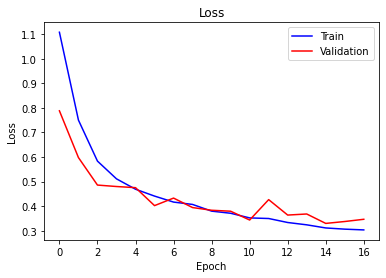

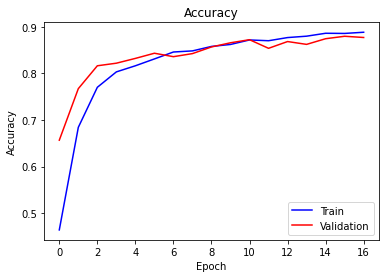

In [ ]:
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

print("Plotting LSTM history")
plot_history(history_LSTM)